# Project 2: Ames Housing Data and Kaggle Challenge
____________

# Part 2 - Modelling, Predictions, and Conclusions

### Riche Ngo, SG-DSI-18

## Problem Statement

Investors and homeowners based in the city of Ames are looking for professionals to aid them in getting the best possible deals when buying/selling housing properties. As part of a real estate agency in Ames looking to boost annual sales, we want to develop the best regression model to predict housing prices and provide expert advice to investors and homeowners on which housing components and features would greatly influence housing prices.

## Executive Summary

This project is part of a [Kaggle challenge](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/overview) and explores the Ames housing data which contains the values for individual residential properties sold in Ames from 2006 to 2010. The dataset also includes information on many housing components and features corresponding to each sale.

Exploratory data analysis revealed strong correlation between the sale price and several housing components. Based on Pearson's correlation coefficient, we were able to segregate the more important features from the not so important ones. We also found there was strong correlation between some of the dependent variables which results in multicollinearity if used together in the regression model. To fix this, the variables were either combined or dropped altogether, leaving the one with higher correlation with the target variable. Many of the features are altered to be more interpretable and categorical data were one-hot encoded to make it readable for the regression model.

Feature engineering was done, where we did a log transformation to the target variable to get a more homoscedastic model as observed through residual plots before and after the transformation. By doing so, the performance of the model in making predictions was improved. Conversely, we saw from scatterplots and correlation coefficients that doing the log tranformation on all the other variables was not necessary a good thing.

Lasso regression was used as a quick feature selection tool and was left with 20 features for model development. Model selection was done by comparing the estimates of the R2 and RMSE scores via the 5-fold cross validation method. We ended up with a Lasso regression model as the production model, with a R2 score of 0.86 and RMSE of 22841 on test(hold-out) data. Since the hold-out method was also adopted, we could compare scores between train and test(hold-out) data and found slight overfitting of the data. But the small difference was acceptable by our means.

The top features which influenced the price predictions the most were found to be the total area of the house, overall quality, neighborhood region of house location, interior finish of the house's garage, and the total number of rooms. Surprisingly, the house age and type of dwelling were not found to be in these top features, likely due to the seasonality of the market and other correlated features.

### Contents:
- [More Feature + Target Engineering](#More-Feature-+-Target-Engineering)
- [Feature Selection](#Feature-Selection)
- [Modeling](#Modeling)
- [Predictions on Test Dataset (Kaggle)](#Predictions-on-Test-Dataset-(Kaggle))
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

sns.set_style('whitegrid')

### Importing data

In [2]:
# Reading in the cleaned train data
path = '../datasets/train_features.csv'
df_train = pd.read_csv(path)

In [3]:
# Displaying top rows of data
df_train.head()

,Id,PID,Garage Finish,Garage Cars,SalePrice,Age Till Sale,Combined Qual,Combined Rms AbvGrd,Combined SF,MS SubClass_Duplex,...,Combined Exterior_OthersMetal,Combined Exterior_OthersOthers,Combined Exterior_OthersVinyl,Combined Exterior_OthersWood,Combined Exterior_VinylOthers,Combined Exterior_VinylVinyl,Combined Exterior_VinylWood,Combined Exterior_WoodOthers,Combined Exterior_WoodVinyl,Combined Exterior_WoodWood
0,109,533352170,2.0,2.0,130500,34.250000,17.0,8.5,2679.0,0,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,2.0,2.0,220000,13.333333,19.0,10.5,3594.0,0,...,0,0,0,0,0,1,0,0,0,0
2,153,535304180,1.0,1.0,109000,57.083333,15.0,6.0,2360.0,0,...,0,0,0,0,0,1,0,0,0,0
3,318,916386060,3.0,2.0,174000,4.333333,15.0,9.5,2228.0,0,...,0,0,0,0,0,1,0,0,0,0
4,255,906425045,1.0,2.0,138500,110.250000,14.0,8.0,2605.0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_train.shape

(2049, 45)

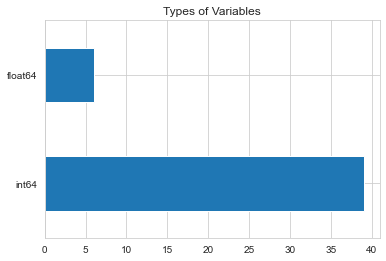

In [5]:
# Checking the data types
df_train.dtypes.value_counts().plot(kind='barh', title='Types of Variables');

## More Feature + Target Engineering

In [6]:
# Pick out the continuous variables
cont_var = ['SalePrice', 'Combined SF', 'Age Till Sale']

In [7]:
df_train[cont_var].describe()

,SalePrice,Combined SF,Age Till Sale
count,2049.000000,2049.000000,2049.000000
mean,181479.018058,3021.236701,36.620872
std,79295.913255,906.638636,30.205129
min,12789.000000,334.000000,0.333333
25%,129800.000000,2384.000000,7.500000
50%,162500.000000,2916.000000,34.250000
75%,214000.000000,3547.000000,54.916667
max,611657.000000,6974.000000,137.000000


### Histograms of continuous features + target

In [8]:
# Function to plot multiple histograms
def subplot_histplot(dataframe, x_list):
    nrows = int(np.ceil(len(x_list)/3))   # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))   
#     plt.subplots_adjust(hspace = 0.4, wspace=0.3)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(x_list):   # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax=ax[i])
        ax[i].axvline(x=dataframe[column].mean() , linewidth=2, color='k', linestyle='dashed')
        ax[i].axvline(x=dataframe[column].median() , linewidth=2, color='m', linestyle='dotted')
        
        min_ylim, max_ylim = ax[i].get_ylim()
        ax[i].text(x=dataframe[column].mean(), y=max_ylim*0.88, s='Mean', rotation=90, color='k')
        ax[i].text(x=dataframe[column].median(), y=max_ylim*0.85, s='Median', rotation=90, color='m')
    
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(x_list):]:
        axes.axis('off')
    plt.suptitle('Histograms of ' + str(x_list), fontsize=15)
    fig.tight_layout()
    pass

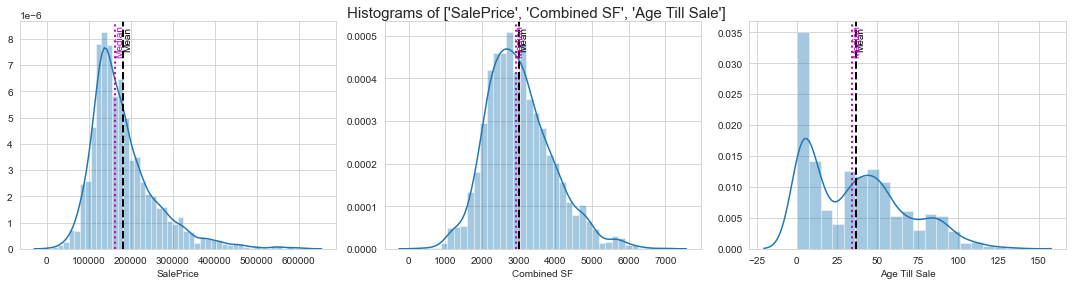

In [9]:
subplot_histplot(df_train, cont_var)

We observe that the variables as follows:
* "SalePrice" has right (positive) skewness and a single spike in frequency.
* "Combined SF" has a slight right (positive) skewness but looks more like a normal distribution in comparison to "SalePrice"
* "Age Till Sale" has a large spike in frequency in the range of about 0-5 years and seems to have a more irregular distribution.

All variables would likely violate the assumption of normality of variables in a linear model. Although, since we are more concerned about predictions rather than conducting statistical inferences, this will not be a major issue. However, to improve the scoring metrics of a linear model, normality in variables is still preferred. Furthermore, skewness in the target variable especially, may result in **heteroscedasticity**. As such, a useful transformation to increase the normality and **homoscedasticity** is by performing a log transformation. We will do the same for the other continuous features to study the effect.

In [10]:
# log transformation
for col in cont_var:
    df_train['log_' + col] = np.log(df_train[col])
    
df_train.head()

,Id,PID,Garage Finish,Garage Cars,SalePrice,Age Till Sale,Combined Qual,Combined Rms AbvGrd,Combined SF,MS SubClass_Duplex,...,Combined Exterior_OthersWood,Combined Exterior_VinylOthers,Combined Exterior_VinylVinyl,Combined Exterior_VinylWood,Combined Exterior_WoodOthers,Combined Exterior_WoodVinyl,Combined Exterior_WoodWood,log_SalePrice,log_Combined SF,log_Age Till Sale
0,109,533352170,2.0,2.0,130500,34.250000,17.0,8.5,2679.0,0,...,0,0,0,0,0,0,1,11.779129,7.893199,3.533687
1,544,531379050,2.0,2.0,220000,13.333333,19.0,10.5,3594.0,0,...,0,0,1,0,0,0,0,12.301383,8.187021,2.590267
2,153,535304180,1.0,1.0,109000,57.083333,15.0,6.0,2360.0,0,...,0,0,1,0,0,0,0,11.599103,7.766417,4.044512
3,318,916386060,3.0,2.0,174000,4.333333,15.0,9.5,2228.0,0,...,0,0,1,0,0,0,0,12.066811,7.708860,1.466337
4,255,906425045,1.0,2.0,138500,110.250000,14.0,8.0,2605.0,0,...,0,0,0,0,0,0,1,11.838626,7.865188,4.702751


### Correlation of transformed features

In [11]:
transformed_cols = [('log_' + col) for col in cont_var]

In [12]:
# Correlation of continuous + transformed features
df_num_transform = pd.concat([df_train[cont_var], df_train[transformed_cols]], axis=1)
corrmat = df_num_transform.corr()

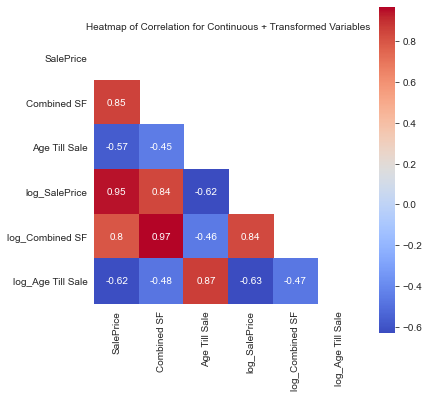

In [13]:
# Using a mask to hide half of the heatmap
# Generating heatmap with divergent colormap, easier to tell if positive or negative correlation
# Blue will mean high positive correlation while red will mean high negative correlation
mask_matrix = np.triu(corrmat)

plt.subplots(figsize=(6,6))
plt.title('Heatmap of Correlation for Continuous + Transformed Variables', fontsize=10)
sns.heatmap(corrmat, cmap='coolwarm', mask=mask_matrix, annot=True, square=True);

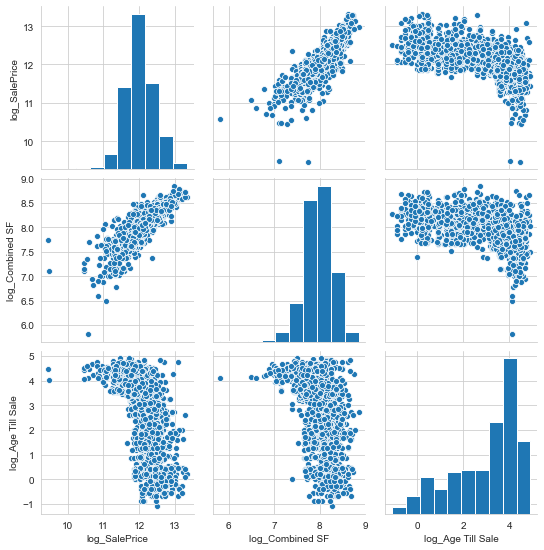

In [14]:
# Pairplot for transformed features
sns.pairplot(df_train[transformed_cols]);

From the correlation heatmap and the pairplot above, we see that doing the log tranformation on all the continuous variables is not necessary a good thing. However, we did observe that the log transformation for the target variable "SalePrice" managed to reduce the skewness and increase the normality of the distribution. The log transformation also strengthened the correlation between "log_SalePrice' and "Age Till Sale". As such, the log transformation for the target variable will be kept.

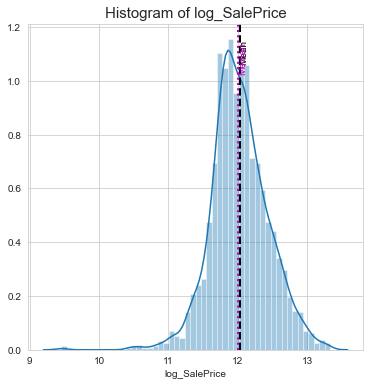

In [15]:
# Visualization to show the improvement in normality of transformed target 'log_SalePrice'
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(df_train['log_SalePrice'], ax=ax)
ax.axvline(x=df_train['log_SalePrice'].mean() , linewidth=2, color='k', linestyle='dashed')
ax.axvline(x=df_train['log_SalePrice'].median() , linewidth=2, color='m', linestyle='dotted')
ax.set_title('Histogram of log_SalePrice', fontsize=15)
min_ylim, max_ylim = ax.get_ylim()
ax.text(x=df_train['log_SalePrice'].mean(), y=max_ylim*0.88, s='Mean', rotation=90, color='k')
ax.text(x=df_train['log_SalePrice'].median(), y=max_ylim*0.85, s='Median', rotation=90, color='m');

In [16]:
# Cleaning up the transformed features that we want to drop
drop_cols = [('log_' + col) for col in cont_var if (col != 'SalePrice')]
df_train.drop(columns=drop_cols, inplace=True)

In [17]:
df_train.shape

(2049, 46)

### Setting the variables

We will set our variables before building the model. We will use the transformed variable "log_SalePrice" as the target for prediction.

In [18]:
# Create our features matrix and target vector
features = [col for col in df_train.columns if (col != 'log_SalePrice' and col != 'SalePrice')]
X = df_train[features]
y = df_train['log_SalePrice']

In [19]:
X.head()

,Id,PID,Garage Finish,Garage Cars,Age Till Sale,Combined Qual,Combined Rms AbvGrd,Combined SF,MS SubClass_Duplex,MS SubClass_OneHalfStorey,...,Combined Exterior_OthersMetal,Combined Exterior_OthersOthers,Combined Exterior_OthersVinyl,Combined Exterior_OthersWood,Combined Exterior_VinylOthers,Combined Exterior_VinylVinyl,Combined Exterior_VinylWood,Combined Exterior_WoodOthers,Combined Exterior_WoodVinyl,Combined Exterior_WoodWood
0,109,533352170,2.0,2.0,34.250000,17.0,8.5,2679.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,2.0,2.0,13.333333,19.0,10.5,3594.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,153,535304180,1.0,1.0,57.083333,15.0,6.0,2360.0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,318,916386060,3.0,2.0,4.333333,15.0,9.5,2228.0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,255,906425045,1.0,2.0,110.250000,14.0,8.0,2605.0,0,1,...,0,0,0,0,0,0,0,0,0,1


We will take out the "Id" and "PID" columns right before we build the model since we will need to split the dataset later on.

### Splitting into Train and Test

We will utilize the Holdout method and split the dataset into train and test sets, where the test set could be used for validation of our model later on.

In [20]:
# Holdout method
# We set random_state = 50 to have reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [21]:
# Separate out the 'Id' and 'PID' columns
X_train_id = X_train.iloc[:, :2]
X_train = X_train.iloc[:, 2:]
X_test_id = X_test.iloc[:, :2]
X_test = X_test.iloc[:, 2:]

In [22]:
X_train.shape

(1536, 42)

In [23]:
X_test.shape

(513, 42)

### Standardizing Data

We will perform scaling on the data using `StandardScaler` from `sklearn`. We include the dummy variables created from encoding the categorical features since we are more concerned with the coefficients and it mostly does not matter.

In [24]:
# Use StandardScaler to scale
ss = StandardScaler()
ss.fit(X_train)   # we always fit with train data
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Feature Selection

Prior to this, the 45 features were fitted into a Linear Regression model but we discovered that the model was severely overfitted and it gave a negative R2 score (i.e. the model was performing worse than the baseline prediction). As such, we want to adopt regularization techniques. We decide to make use of **Lasso Regression** and its innate feature selection ability to trim down the less impactful features.  

Using Lasso Regression as a feature selection method is fast in terms of inference and fitting, but because it is automatic, it may produce a model that does not make sense. It may choose to ignore nonsignificant variables that are actually important or relevant, also because it may randomly select one feature from a group of highly correlated features. As such, we will have to eyeball the features that will be dropped and decide whether it is acceptable before affirming the selection.

In [25]:
# Lasso model
# Selecting 100 alphas
lasso = LassoCV(n_alphas = 100) 
lasso.fit(X_train_scaled, y_train)

LassoCV()

In [26]:
# Looking at the alpha value for Lasso model
lasso.alpha_

0.004091131204776943

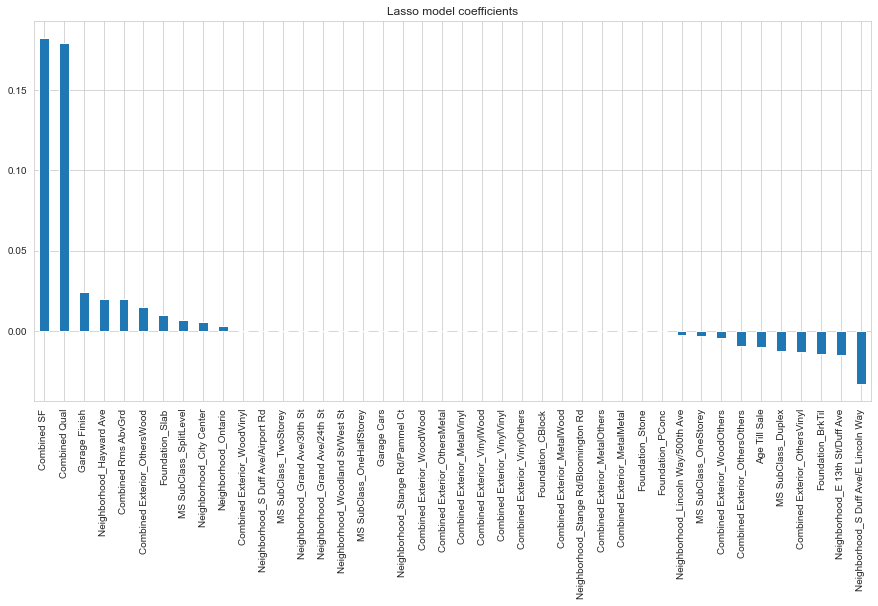

In [27]:
# Plotting the lasso coefficients on bar plot
plt.figure(figsize=(15,7))
plt.title('Lasso model coefficients', fontsize=12)
pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False).plot.bar();

We will select the features which has a lasso coefficient of absolute value > 0.001.

In [28]:
# Check number of features to be kept
len(lasso.coef_[abs(lasso.coef_)>=0.001])

20

In [29]:
# Filter out these features
features_2 = X_train.columns[abs(lasso.coef_)>=0.001]
features_2

Index(['Garage Finish', 'Age Till Sale', 'Combined Qual',
       'Combined Rms AbvGrd', 'Combined SF', 'MS SubClass_Duplex',
       'MS SubClass_OneStorey', 'MS SubClass_SplitLevel',
       'Neighborhood_City Center', 'Neighborhood_E 13th St/Duff Ave',
       'Neighborhood_Hayward Ave', 'Neighborhood_Lincoln Way/500th Ave',
       'Neighborhood_Ontario', 'Neighborhood_S Duff Ave/E Lincoln Way',
       'Foundation_BrkTil', 'Foundation_Slab',
       'Combined Exterior_OthersOthers', 'Combined Exterior_OthersVinyl',
       'Combined Exterior_OthersWood', 'Combined Exterior_WoodOthers'],
      dtype='object')

In [30]:
# Reset the train and test sets
X_train = X_train[features_2]
X_test = X_test[features_2]

In [31]:
X_train.shape

(1536, 20)

In [32]:
X_test.shape

(513, 20)

## Modeling

We need to perform scaling again with the 20 features.

In [33]:
# Use StandardScaler to scale
ss = StandardScaler()
ss.fit(X_train)   # we always fit with train data
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

### Baseline Score  

If we want to generate the same predicted $y$ value for all of the observations, the best $y$ value to predict is the mean of the target variable. This is known as the **baseline/null prediction**.

We want to find out what is the RMSE for the baseline prediction to be used for comparison later on.

In [34]:
# Null prediction
df_train['null_prediction'] = np.mean(df_train['SalePrice'])

In [35]:
# RMSE of baseline score
baseline_rmse = np.sqrt(metrics.mean_squared_error(y, df_train['null_prediction']))
print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 181466.9936884632


In [36]:
# Drop the null_prediction column
df_train.drop(columns='null_prediction', inplace=True)

### Linear Regression Model
We first build a model using linear regression and obtain the R2 and RMSE. We will then build other models to compare the scores. Note that because this project is done for Kaggle's [Regression Challenge](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge), it is more important to get a lower RMSE than to get a higher R2.

In [37]:
# Create LinearRegression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)

In [38]:
# Initiate lists of train and test score
# To visualize in a dataframe
model_name = []
r2_train = []
r2_cv_estimate = []
adj_r2_train = []
adj_r2_cv_estimate = []
rmse_train = []
rmse_cv_estimate = []

In [39]:
# Function for adjusted r2
# n is the number of points in data sample
# k is number of independent regressors / terms
r2_adj = lambda r2, n, k: 1 - (1-r2)*(n-1)/(n-k-1)

We use **cross validation** to obtain an estimate of the score on unseen data. Note that because we did a log transformation on the target variable "SalePrice", so the RMSE from `cross_val_score` and training will be of a different unit. There is no need to transform it right now as the values are mainly used to select the best performaing model. The transformation will not affect the R2 score.

In [40]:
# Linear Regression scores
# cross validation with 5-folds
model_name.append('Linear Regression')
r2_train.append(lr.score(X_train_scaled, y_train))
r2_cv_estimate.append(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean())
adj_r2_train.append(r2_adj(lr.score(X_train_scaled, y_train), X_train_scaled.shape[0], X_train_scaled.shape[1]))
adj_r2_cv_estimate.append(r2_adj(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(), X_train_scaled.shape[0], X_train_scaled.shape[1]))
rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
rmse_cv_estimate.append(-cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

In [41]:
# Visualize in dataframe
pd.DataFrame({'model': model_name,
             'r2_train': r2_train,
             'r2_cv_estimate': r2_cv_estimate,
             'adj_r2_train': adj_r2_train,
             'adj_r2_cv_estimate': adj_r2_cv_estimate,
             'rmse_train': rmse_train,
             '(log)rmse_cv_estimate': rmse_cv_estimate})

,model,r2_train,r2_cv_estimate,adj_r2_train,adj_r2_cv_estimate,rmse_train,(log)rmse_cv_estimate
0,Linear Regression,0.863296,0.850527,0.861491,0.848553,0.155803,0.16223


We observe that the r2 test score is lower than the r2 train score which may indicate some slight overfitting of the data. Also, the RMSE test value is higher than the RMSE train value, which also means slight overfitting.

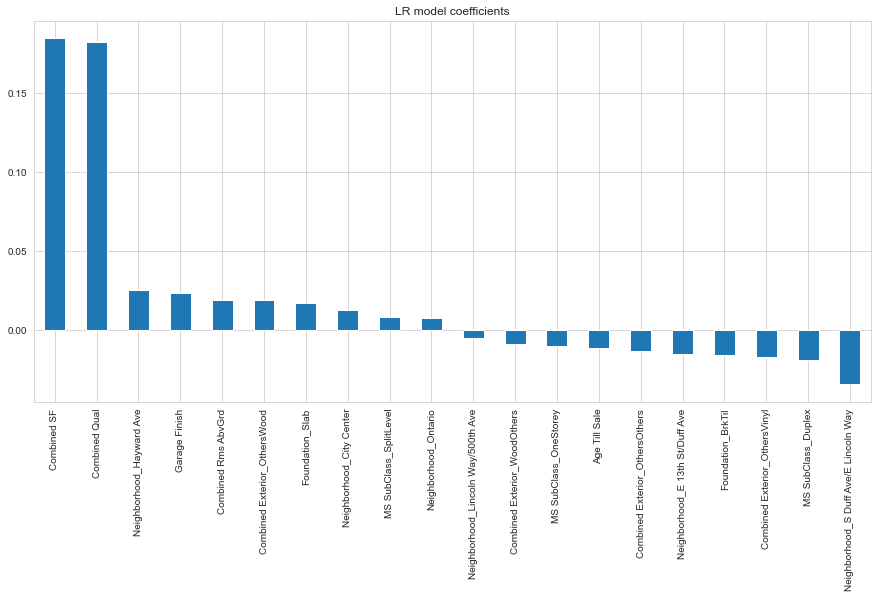

In [42]:
# Plotting the linear coefficients on bar plot
plt.figure(figsize=(15,7))
plt.title('LR model coefficients', fontsize=12)
pd.Series(lr.coef_, index=X_train.columns).sort_values(ascending=False).plot.bar();

We observe quite a large disparity in the coefficients for the Linear Regression model. The most influential features on the target variable are **Combined SF** and **Combined Qual**.

### Ridge Regression Model

In [43]:
# RidgeCV model to get optimal alpha
r_alphas = np.linspace(0.1, 10, 200)
ridge = RidgeCV(alphas = r_alphas)
ridge.fit(X_train_scaled, y_train);

In [44]:
# Optimal alpha value
opt_ridge_alpha = ridge.alpha_
opt_ridge_alpha

10.0

In [45]:
# Ridge model with optimal alpha
ridge = Ridge(alpha=opt_ridge_alpha)
ridge.fit(X_train_scaled, y_train)
y_pred_train = ridge.predict(X_train_scaled)

In [46]:
# Ridge scores
# cross validation with 5-folds
model_name.append('Ridge Regression')
r2_train.append(ridge.score(X_train_scaled, y_train))
r2_cv_estimate.append(cross_val_score(ridge, X_train_scaled, y_train, cv=5).mean())
adj_r2_train.append(r2_adj(ridge.score(X_train_scaled, y_train), X_train_scaled.shape[0], X_train_scaled.shape[1]))
adj_r2_cv_estimate.append(r2_adj(cross_val_score(ridge, X_train_scaled, y_train, cv=5).mean(), X_train_scaled.shape[0], X_train_scaled.shape[1]))
rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
rmse_cv_estimate.append(-cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

In [47]:
# Visualize in dataframe
pd.DataFrame({'model': model_name,
             'r2_train': r2_train,
             'r2_cv_estimate': r2_cv_estimate,
             'adj_r2_train': adj_r2_train,
             'adj_r2_cv_estimate': adj_r2_cv_estimate,
             'rmse_train': rmse_train,
             'rmse_cv_estimate': rmse_cv_estimate})

,model,r2_train,r2_cv_estimate,adj_r2_train,adj_r2_cv_estimate,rmse_train,rmse_cv_estimate
0,Linear Regression,0.863296,0.850527,0.861491,0.848553,0.155803,0.162230
1,Ridge Regression,0.863268,0.850658,0.861463,0.848686,0.155819,0.162156


We see some slight improvement in the cross validation estimates for the R2 score and RMSE in the Ridge model as compared to the Linear Regression model.

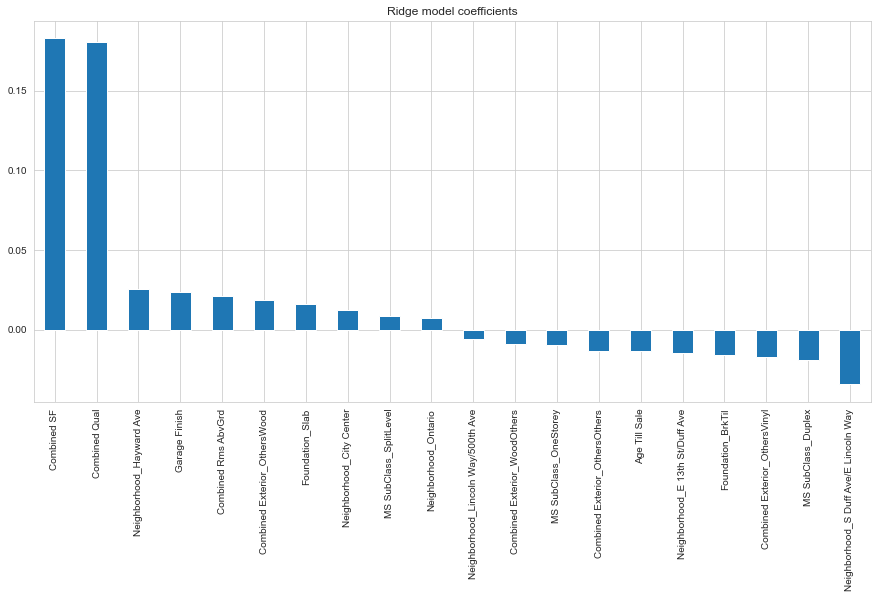

In [48]:
# Plotting the ridge coefficients on bar plot
plt.figure(figsize=(15,7))
plt.title('Ridge model coefficients', fontsize=12)
pd.Series(ridge.coef_, index=X_train.columns).sort_values(ascending=False).plot.bar();

Similarly, we observe quite a large disparity in the coefficients for the Ridge Regression model. The most influential features on the target variable are **Combined SF** and **Combined Qual**. In addition, the order of influence each feature has on the target variable is exactly the same as the Linear Regression model.

### Lasso Regression Model

In [49]:
# Lasso model
# Selecting 100 alphas
lasso = LassoCV(n_alphas = 100) 
lasso.fit(X_train_scaled, y_train);

In [50]:
# Optimal alpha value
opt_lasso_alpha = lasso.alpha_
opt_lasso_alpha

0.0033184426530003365

In [51]:
# Lasso model with optimal alpha
lasso = Lasso(alpha=opt_lasso_alpha)
lasso.fit(X_train_scaled, y_train)
y_pred_train = lasso.predict(X_train_scaled)

In [52]:
# Lasso scores
# cross validation with 5-folds
model_name.append('Lasso Regression')
r2_train.append(lasso.score(X_train_scaled, y_train))
r2_cv_estimate.append(cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean())
adj_r2_train.append(r2_adj(lasso.score(X_train_scaled, y_train), X_train_scaled.shape[0], X_train_scaled.shape[1]))
adj_r2_cv_estimate.append(r2_adj(cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean(), X_train_scaled.shape[0], X_train_scaled.shape[1]))
rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
rmse_cv_estimate.append(-cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

In [53]:
# Visualize in dataframe
pd.DataFrame({'model': model_name,
             'r2_train': r2_train,
             'r2_cv_estimate': r2_cv_estimate,
             'adj_r2_train': adj_r2_train,
             'adj_r2_cv_estimate': adj_r2_cv_estimate,
             'rmse_train': rmse_train,
             'rmse_cv_estimate': rmse_cv_estimate})

,model,r2_train,r2_cv_estimate,adj_r2_train,adj_r2_cv_estimate,rmse_train,rmse_cv_estimate
0,Linear Regression,0.863296,0.850527,0.861491,0.848553,0.155803,0.162230
1,Ridge Regression,0.863268,0.850658,0.861463,0.848686,0.155819,0.162156
2,Lasso Regression,0.862256,0.851643,0.860438,0.849684,0.156394,0.161574


We see some slight improvement in the cross validation estimates for the R2 score and RMSE in the Lasso model as compared to the other models. The Lasso model is performing the best so far.

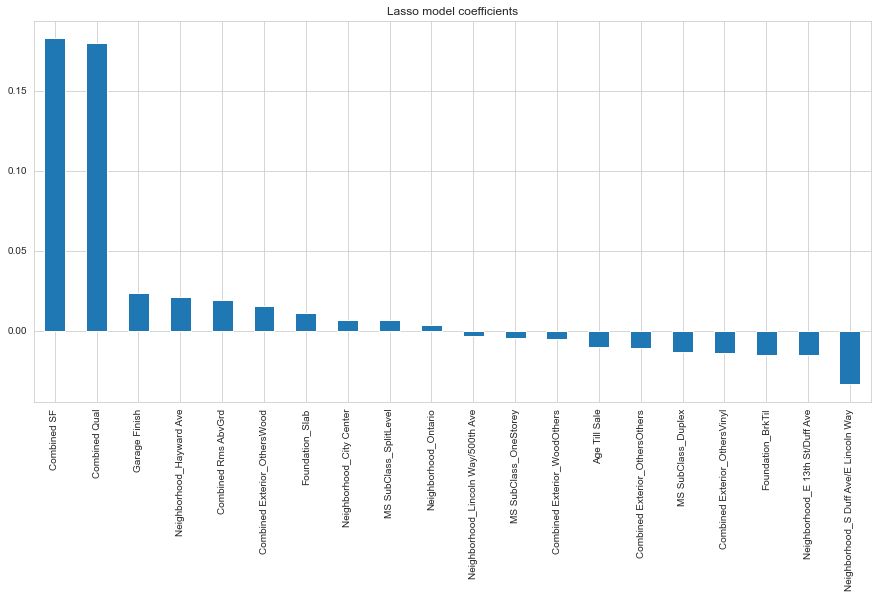

In [54]:
# Plotting the lasso coefficients on bar plot
plt.figure(figsize=(15,7))
plt.title('Lasso model coefficients', fontsize=12)
pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False).plot.bar();

We observe quite a large disparity in the coefficients for the Lasso Regression model. The most influential features on the target variable are **Combined SF** and **Combined Qual**. The order of influence each feature has on the target variable is slightly different as compared to the Ridge/Linear Regression models.

### ElasticNet Regression Model

In [55]:
# ElasticNet model
en_alphas = np.arange(0.001, 1, 0.005)
en_ratio = np.arange(0.01, 0.99, 0.01)
en_model = ElasticNetCV(alphas = en_alphas, l1_ratio=en_ratio, cv=5)
en_model.fit(X_train_scaled, y_train);

In [56]:
# Optimal alpha value & l1 ratio
opt_en_alpha = en_model.alpha_
opt_en_ratio = en_model.l1_ratio_
[opt_en_alpha, opt_en_ratio]

[0.006, 0.54]

In [57]:
# ElasticNet model with optimal alpha
en_model = ElasticNet(alpha=opt_en_alpha, l1_ratio=opt_en_ratio)
en_model.fit(X_train_scaled, y_train)
y_pred_train = en_model.predict(X_train_scaled)

In [58]:
# ElasticNet scores
# cross validation with 5-folds
model_name.append('ElasticNet Regression')
r2_train.append(en_model.score(X_train_scaled, y_train))
r2_cv_estimate.append(cross_val_score(en_model, X_train_scaled, y_train, cv=5).mean())
adj_r2_train.append(r2_adj(en_model.score(X_train_scaled, y_train), X_train_scaled.shape[0], X_train_scaled.shape[1]))
adj_r2_cv_estimate.append(r2_adj(cross_val_score(en_model, X_train_scaled, y_train, cv=5).mean(), X_train_scaled.shape[0], X_train_scaled.shape[1]))
rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
rmse_cv_estimate.append(-cross_val_score(en_model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

In [59]:
# Visualize in dataframe
pd.DataFrame({'model': model_name,
             'r2_train': r2_train,
             'r2_cv_estimate': r2_cv_estimate,
             'adj_r2_train': adj_r2_train,
             'adj_r2_cv_estimate': adj_r2_cv_estimate,
             'rmse_train': rmse_train,
             'rmse_cv_estimate': rmse_cv_estimate})

,model,r2_train,r2_cv_estimate,adj_r2_train,adj_r2_cv_estimate,rmse_train,rmse_cv_estimate
0,Linear Regression,0.863296,0.850527,0.861491,0.848553,0.155803,0.162230
1,Ridge Regression,0.863268,0.850658,0.861463,0.848686,0.155819,0.162156
2,Lasso Regression,0.862256,0.851643,0.860438,0.849684,0.156394,0.161574
3,ElasticNet Regression,0.862257,0.851638,0.860439,0.849679,0.156394,0.161577


The Lasso model is performing the best so far.

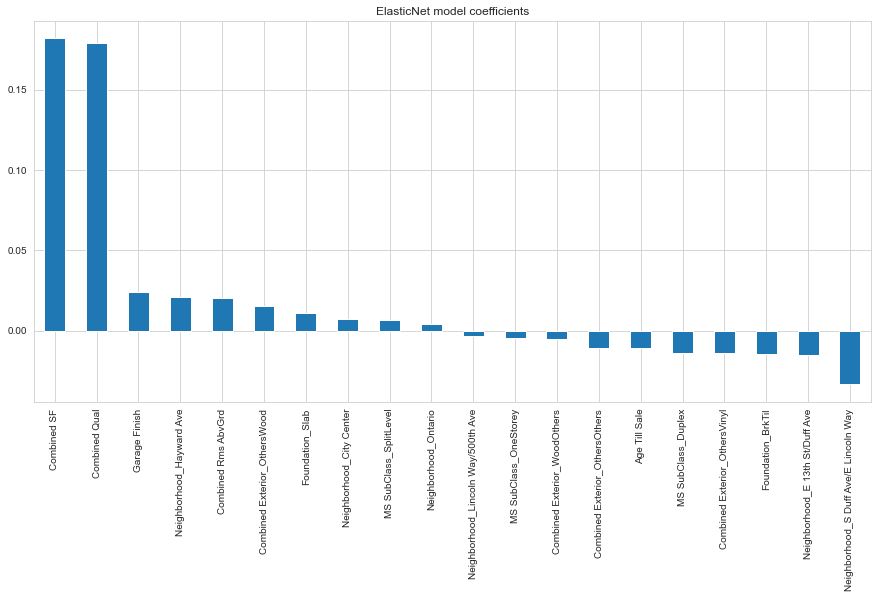

In [60]:
# Plotting the ElasticNet coefficients on bar plot
plt.figure(figsize=(15,7))
plt.title('ElasticNet model coefficients', fontsize=12)
pd.Series(en_model.coef_, index=X_train.columns).sort_values(ascending=False).plot.bar();

We observe quite a large disparity in the coefficients for the ElasticNet Regression model. The most influential features on the target variable are **Combined SF** and **Combined Qual**. The order of influence each feature has on the target variable is more similar to the Lasso Regression model's except there is a swap in positions between "Age Till Sale" and "Combined Exterior_OthersOthers".

### Production Model

Based on the comparison of the RMSE and R2 estimated scores among all the models, the best performing model is the **Lasso Regression model**. This will be the production model also due to the following reasons:  
* There seems to be overfitting in the linear model even after trimming them down during Feature Selection. Lasso Regression is a regularization technique and helps to generalize the overfitted model.  
* As seen from the disparity in the coefficients of the linear model, it would mean that there are some features with large coefficients and more power to change the predicted response, resulting in higher variance. Lasso Regression **penalizes** the model for having large coefficients which also helps in generalizing the model.  

In spite of that, we must be aware that the Lasso Regression model still has some caveats. It is commonly known that the prediction power of Lasso is not as strong as the Ridge or ElasticNet, especially for correlated features. But in this case, we did quite an elaborate EDA and took the time to drop any features that were highly correlated. Using the Lasso Regression model is further substantiated by the RMSE score performing better than its counterparts. As such, we decide to follow through with the Lasso Regression model.

We want to bring back "X_test" and "y_test" which we split from the full training dataset and compare the scores. We want to observe if there are major differences in scores, this is the advantage of using the **Hold-out Method** in conjunction with **Cross Validation**.

Moreover, we will do a reverse transformation by means of `np.exp` on the 'y' variable to have a more meaningful value to compare with. The units of the RMSE will be the same as "SalePrice", in dollars.

In [61]:
# Scoring on the production model
# comparing between X_train and X_test
production_model = lasso
y_pred_train = production_model.predict(X_train_scaled)
y_pred_test = production_model.predict(X_test_scaled)

print('Train Scores\n------------')
print(f'R2 train score: {production_model.score(X_train_scaled, y_train)}')
print(f'R2(adj) train score: {r2_adj(production_model.score(X_train_scaled, y_train), X_train_scaled.shape[0], X_train_scaled.shape[1])}')
print(f'RMSE train score: {np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_pred_train)))}')
print()
print('Test(Hold-out) Scores\n------------')
print(f'R2 test score: {production_model.score(X_test_scaled, y_test)}')
print(f'R2(adj) test score: {r2_adj(production_model.score(X_test_scaled, y_test), X_test_scaled.shape[0], X_test_scaled.shape[1])}')
print(f'RMSE test score: {np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))}')

Train Scores
------------
R2 train score: 0.8622564048744541
R2(adj) train score: 0.8604380075790674
RMSE train score: 26255.754090377373

Test(Hold-out) Scores
------------
R2 test score: 0.87005863164397
R2(adj) test score: 0.8647764621986029
RMSE test score: 22841.322894294306


We observe that the test(hold-out) scores are slightly better than the train scores, i.e. R2 score increased by 0.5% and RMSE decreased by 13%. The differences between the train and test(hold-out) scores indicate that there may be some overfitting and also different statistics between the two sets of data after we split it. In spite of that, the differences are not large and it is still acceptable.

**Compare to baseline score**  
*Baseline RMSE: 181466.9936884632*  
Comparing the scores to the baseline RMSE, we see a significant 87% decrease in error from the baseline RMSE. This is due to the fact that the linear model is much more fitted to the data as compared to just predicting the $y$ value to be the mean of the target variable. In other words, there is a much higher bias in the baseline prediction. It is also a strong indication that the model is performing much better than the baseline predictions. 

In [62]:
pd.Series(y_train)

2030    12.154779
1911    11.775290
2012    12.125405
1873    12.043554
120     11.589887
          ...    
1313    12.429216
109     12.075394
1931    12.037654
1504    11.838626
1712    11.845820
Name: log_SalePrice, Length: 1536, dtype: float64

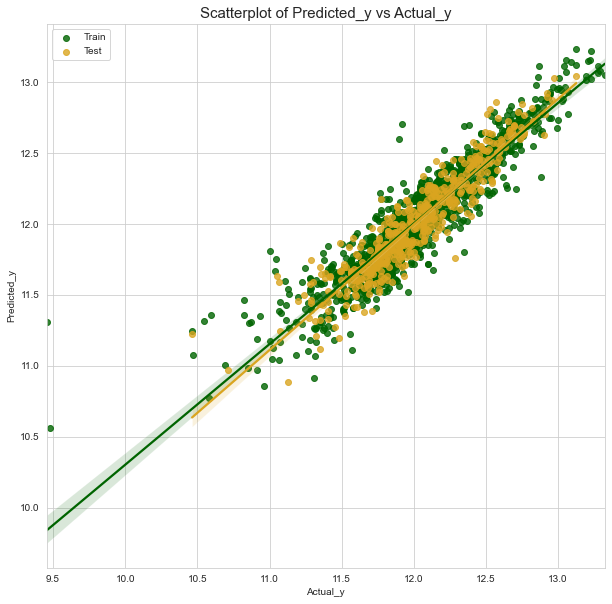

In [63]:
# Look at how our predictions compare to the true values.
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.regplot(x=pd.Series(y_train), y=pd.Series(y_pred_train), color='darkgreen', ax=ax, label='Train')
sns.regplot(x=pd.Series(y_test), y=pd.Series(y_pred_test), color='goldenrod', ax=ax, label='Test')
ax.set_title('Scatterplot of Predicted_y vs Actual_y', fontsize=15)
ax.legend()
ax.set(xlabel='Actual_y', ylabel='Predicted_y');

Plotting the predicted $y$ values against the actual $y$ values, we could see a strong linear relationship between them. This is a tell-tale sign of a decent model. Moreover, we can see from the regplot that the difference between the regression lines of the train data and test data is not large. It further substantiates the selection of this model.

#### Residual plots  
We are interested to see if the log transformation on target variable has improved the **homoscedasticity** of the model. We will generate predictions for the non-transformed target variable using the same production model (although it may not be the best model if the target variable is not transformed) and compare the residuals with the predictions for the transformed target variable.

In [64]:
# Generate predictions for non-log of SalePrice
y_train_nonlog = np.exp(y_train)
y_test_nonlog = np.exp(y_test)
lasso.fit(X_train_scaled, y_train_nonlog)
y_pred_train_nonlog = lasso.predict(X_train_scaled)
y_pred_test_nonlog = lasso.predict(X_test_scaled)

# Residuals
res_train = np.exp(y_train) - np.exp(y_pred_train)   # np.exp here to have more meaningful comparison
res_test = np.exp(y_test) - np.exp(y_pred_test)
res_train_nonlog = y_train_nonlog - y_pred_train_nonlog
res_test_nonlog = y_test_nonlog - y_pred_test_nonlog

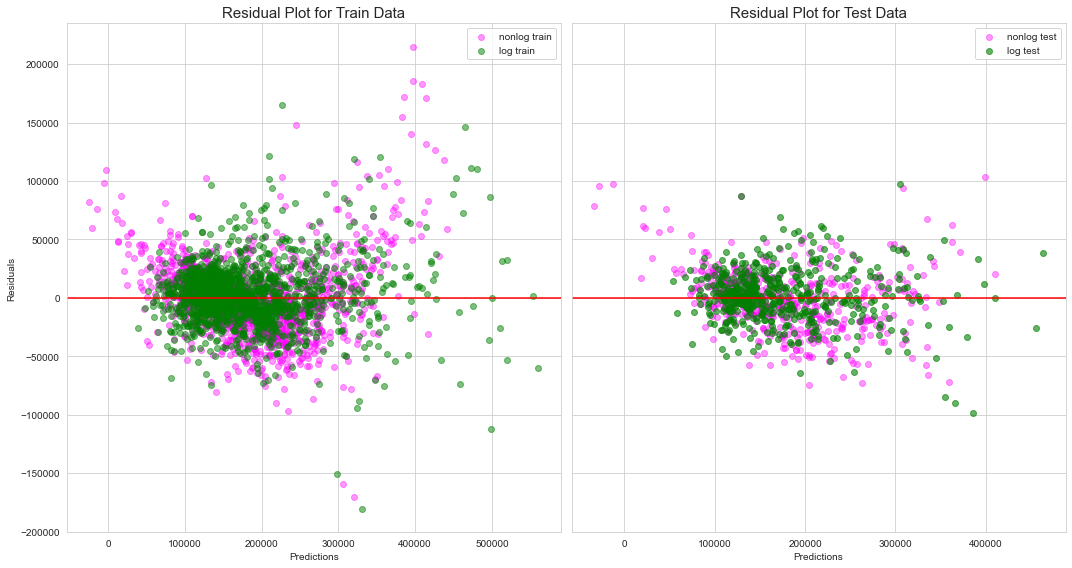

In [65]:
# Residual plots
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharey=True)

ax[0].scatter(y_pred_train_nonlog, res_train_nonlog, alpha=0.4, color='magenta', label='nonlog train')
ax[0].scatter(np.exp(y_pred_train), res_train, alpha=0.5, color='green', label='log train')
ax[0].axhline(0, color='red')
ax[0].set_title('Residual Plot for Train Data', fontsize=15)
ax[0].set(xlabel='Predictions', ylabel='Residuals')
ax[0].legend()

ax[1].scatter(y_pred_test_nonlog, res_test_nonlog, alpha=0.4, color='magenta', label='nonlog test')
ax[1].scatter(np.exp(y_pred_test), res_test, alpha=0.6, color='green', label='log test')
ax[1].axhline(0, color='red')
ax[1].set_title('Residual Plot for Test Data', fontsize=15)
ax[1].set(xlabel='Predictions')
ax[1].legend()
fig.tight_layout();

From the residual plots, we can observe that doing a log transformation on the target variable indeed helped to achieve a more **homoscedastic** model. Particularly looking at the left side of each plot, we can see a notable inequality in the variance of residuals for the non-log version of the target variable (as shown in magenta color). The inequality is not present after the target variable underwent a log transformation (as shown in green color). We are further convinced in performing the log transformation on the target variable.

#### Building the model

We will build the production model now using the entire training dataset.

In [66]:
# Using the full training dataset
X_full = X[features_2]

In [67]:
X_full.shape

(2049, 20)

In [68]:
# Scaling with the full training dataset
X_full_scaled = ss.fit_transform(X_full)

In [69]:
# Assign to variable
# Fit with full train data
production_model.fit(X_full_scaled, y)

Lasso(alpha=0.0033184426530003365)

In [70]:
# Intercept
production_model.intercept_

12.024369592215619

In [71]:
# Features of production model
features_2

Index(['Garage Finish', 'Age Till Sale', 'Combined Qual',
       'Combined Rms AbvGrd', 'Combined SF', 'MS SubClass_Duplex',
       'MS SubClass_OneStorey', 'MS SubClass_SplitLevel',
       'Neighborhood_City Center', 'Neighborhood_E 13th St/Duff Ave',
       'Neighborhood_Hayward Ave', 'Neighborhood_Lincoln Way/500th Ave',
       'Neighborhood_Ontario', 'Neighborhood_S Duff Ave/E Lincoln Way',
       'Foundation_BrkTil', 'Foundation_Slab',
       'Combined Exterior_OthersOthers', 'Combined Exterior_OthersVinyl',
       'Combined Exterior_OthersWood', 'Combined Exterior_WoodOthers'],
      dtype='object')

In [72]:
# Coefficients
production_model.coef_

array([ 0.02365257, -0.01817126,  0.16794093,  0.0212986 ,  0.18241399,
       -0.01342774, -0.0033301 ,  0.00678735,  0.00471152, -0.01094042,
        0.02566285, -0.00428918,  0.00459361, -0.02585399, -0.01570428,
        0.0125623 , -0.00518253, -0.01248454,  0.01171934, -0.00546727])

In [73]:
# Sort the features by coefficients
feature_importance = pd.DataFrame(data=production_model.coef_, index=features_2, columns=['Coefficients']).sort_values(by='Coefficients', ascending=False)
feature_importance['Influence'] = feature_importance['Coefficients'].map(lambda c: 'Positive' if c>0 else 'Negative')
feature_importance

,Coefficients,Influence
Combined SF,0.182414,Positive
Combined Qual,0.167941,Positive
Neighborhood_Hayward Ave,0.025663,Positive
Garage Finish,0.023653,Positive
Combined Rms AbvGrd,0.021299,Positive
Foundation_Slab,0.012562,Positive
Combined Exterior_OthersWood,0.011719,Positive
MS SubClass_SplitLevel,0.006787,Positive
Neighborhood_City Center,0.004712,Positive
Neighborhood_Ontario,0.004594,Positive


In [74]:
# Sort according to absolute value of coefficients
sorted_feature_importance = feature_importance.loc[abs(feature_importance['Coefficients']).sort_values().index, ['Coefficients', 'Influence']]

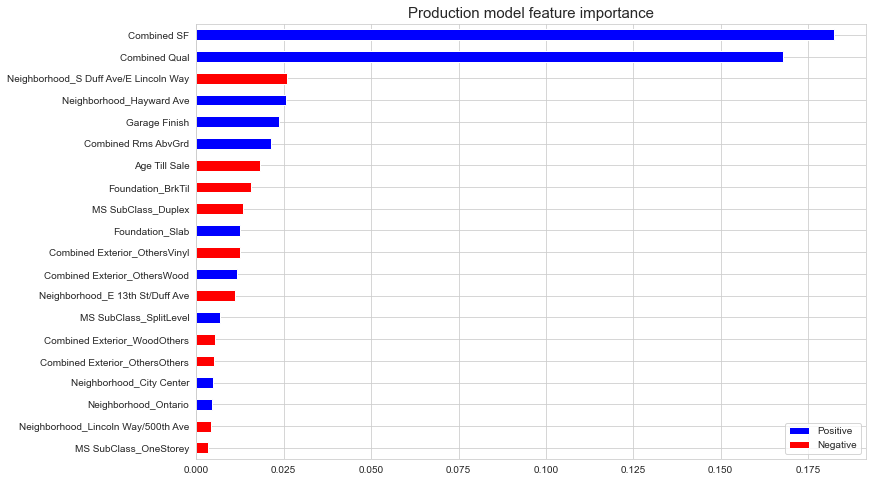

In [75]:
# Plotting the features importance on bar plot
# we will order them by absolute values to have a more meaningful interpretation
from matplotlib.patches import Patch
colors = {'Positive':'blue', 'Negative':'red'}
plt.figure(figsize=(12,8))
plt.title('Production model feature importance', fontsize=15)
abs(sorted_feature_importance['Coefficients']).plot.barh(color=sorted_feature_importance['Influence'].replace(colors))
plt.legend([Patch(facecolor=colors['Positive']), Patch(facecolor=colors['Negative'])], ['Positive', 'Negative']);

We see that the top features by order of importance in the prediction of SalePrice are:  
1. **Combined SF** - Total area of the house in square feet. As the total area of the house increases, the sale price of the house increases significantly. This is expected as it is common understading that larger houses are more expensive.  
2. **Combined Qual** - Combined rating of the overall material, finish, amenities, and exterior of the house. As the combined rating increases, the sale price of the house increases significantly. This is likely due to practical reasons whereby less renovation works is required if the quality of the aforementioned items are up to standard. Demand for houses with a high rating will be high, therefore increases the sale price significantly.  
3. **Neighborhood** - The physical location of the house, by neighborhood region. Houses in the S Duff Ave/E Lincoln Way neighborhood are relatively cheaper, while houses in the Hayward Ave neighborhood are relatively more expensive. We can do more research on these neighborhoods.  
4. **Garage Finish** - Interior finish of garage. The garage is almost always the first thing people see when they drive to the house and the last thing people see when they leave the house. Having a finished garage interior will likely form a stronger first impression to buyers and it may increases the demand of the house. This also means that they will be more likely to buy it at a higher price.  
5. **Combined Rms AbvGrd** - Number of all rooms above grade. As the number of rooms above grade increases, the sale price of the house increases. This is expected since one of the main motivators for buying a house is to have living space. The number of rooms directly relates to the amount of living spaces available for people to utilise.

Although **Age Till Sale**, which represents the number of years from when the house was built to the time of sale, did not make it to the top 5 features by order of importance in prediction of SalePrice, it is a strong contender and is still an honorable mention. It is known in the domain that the age of the house does play a big part in the price of a house, and generally the older the house, the cheaper it is. But a possible reason as to why it did not make it to the top 5 features could be because the age of the house may not be linearly related to the sale price. We also observed previously from the histogram that the distribution for house age has several spikes in frequencies, which violates the assumption of linearity. It could also indicate a cyclic relationship with sale price, where the sale price increases during certain periods of a year. Based on [research](https://www.investopedia.com/articles/investing/010717/seasons-impact-real-estate-more-you-think.asp#:~:text=One%20of%20the%20factors%20impacting,that%20for%20a%20seasonal%20discount%3F), one of the factors impacting housing supply and demand is the seasonality of the market. As such, breaking down the house age further may have had a different effect on the linear model.

## Predictions on Test Dataset (Kaggle)

With a production model, we can bring in the `test.csv` dataset provided by Kaggle and prepare it for predictions to be submitted.

### Importing test data

In [76]:
# Reading in the test data
path = '../datasets/test.csv'
df_test = pd.read_csv(path)

In [77]:
# Displaying top rows of data
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [78]:
df_test.shape

(879, 80)

In [79]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     719 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        879 non-null    object 
 9   Land Contour     879 non-null    object 
 10  Utilities        879 non-null    object 
 11  Lot Config       879 non-null    object 
 12  Land Slope       879 non-null    object 
 13  Neighborhood     879 non-null    object 
 14  Condition 1      879 non-null    object 
 15  Condition 2      879 non-null    object 
 16  Bldg Type        879 non-null    object 
 17  House Style     

In [80]:
# Changing the type for 'MS SubClass'
df_test['MS SubClass'] = df_test['MS SubClass'].astype(str)
df_test['MS SubClass'].dtypes

dtype('O')

In [81]:
# Check if target variable in test dataset
if 'SalePrice' in df_test.columns:
    print('SalePrice is present')
else:
    print('Nope.')

Nope.


### Cleaning Test Dataset

#### Missing Values

In [82]:
# See the columns with null values
pd.set_option('display.max_rows', None)
mv = df_test.isnull().sum().sort_values(ascending=False)
# Filter out missing values
mv = mv[mv.values > 0]
mv_percent = mv / df_test.shape[0] * 100
pd.concat([mv, mv_percent], axis=1, keys=['Total', 'Percentage'])

,Total,Percentage
Pool QC,875,99.544937
Misc Feature,838,95.335609
Alley,821,93.401593
Fence,707,80.432309
Fireplace Qu,422,48.009101
Lot Frontage,160,18.202503
Garage Cond,45,5.119454
Garage Qual,45,5.119454
Garage Yr Blt,45,5.119454
Garage Finish,45,5.119454


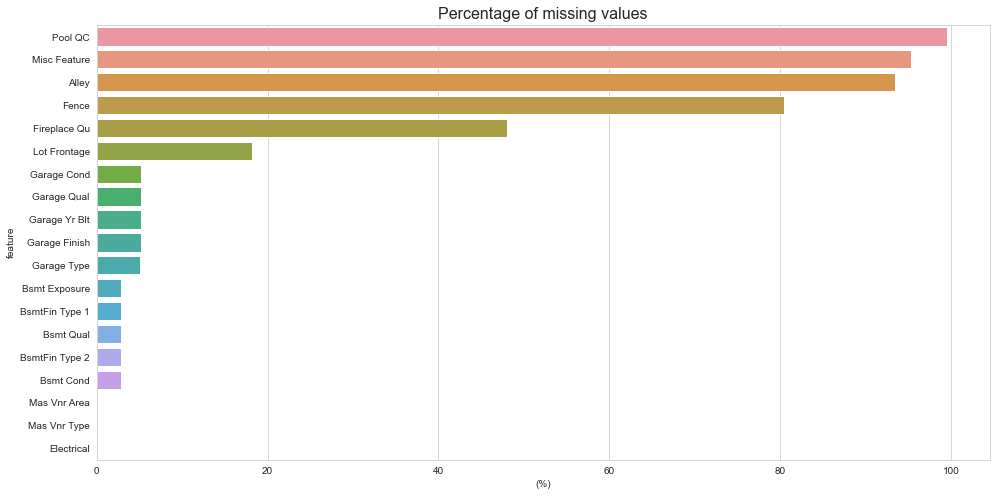

In [83]:
# Plot the missing values using a bar plot
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.barplot(mv_percent.values,mv_percent.index)
ax.set_xlabel('(%)')
ax.set_ylabel('feature')
ax.set_title('Percentage of missing values', fontsize=16);

We see that most of the features that are associated with each other (e.g. Bsmt features) tally on the number of null values except for "Garage Type" where it has one less null value than its related features. Also, we see that "Electrical" has a null value which is likely missing completely at random (MCAR).

In [84]:
# Value with highest occurrence in 'Electrical'
df_test['Electrical'].mode()

0    SBrkr
dtype: object

In [85]:
# Impute value for MCAR 'Electrical' value
df_test.loc[df_test['Electrical'].isnull(), ['Electrical']] = 'SBrkr'

In [86]:
# Checking discrepancy for 'Garage Type'
df_test.loc[(df_test['Garage Type'].notnull()) & ((df_test['Garage Cond'].isnull()) & (df_test['Garage Qual'].isnull()) & (df_test['Garage Yr Blt'].isnull()) & (df_test['Garage Finish'].isnull())),
             ['Garage Cond', 'Garage Qual', 'Garage Yr Blt', 'Garage Finish', 'Garage Type']]

,Garage Cond,Garage Qual,Garage Yr Blt,Garage Finish,Garage Type
765,NaN,NaN,NaN,NaN,Detchd


We observe that there is a discrepancy in the "Garage Type" column in comparison with the other Garage related columns. All the other Garage features in the row data indicates that there is no garage in this data entry. It is safe to assume that the value in "Garage Type" was a wrong entry and should be a value that indicates no garage. Hence, we will impute the value "na".

In [87]:
# Imputation
df_test.loc[[765], 'Garage Type'] = 'na'

In [88]:
# Mapping ordinal variables
df_test['Lot Shape'] = df_test['Lot Shape'].map({'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4})
df_test['Utilities'] = df_test['Utilities'].map({'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4})
df_test['Land Slope'] = df_test['Land Slope'].map({'Sev': 1, 'Mod': 2, 'Gtl': 3})
df_test['Exter Qual'] = df_test['Exter Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5})
df_test['Exter Cond'] = df_test['Exter Cond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5})
df_test['Bsmt Qual'] = df_test['Bsmt Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Bsmt Cond'] = df_test['Bsmt Cond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Bsmt Exposure'] = df_test['Bsmt Exposure'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['BsmtFin Type 1'] = df_test['BsmtFin Type 1'].map({'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})
df_test['BsmtFin Type 2'] = df_test['BsmtFin Type 2'].map({'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})
df_test['Heating QC'] = df_test['Heating QC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Electrical'] = df_test['Electrical'].map({'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5})
df_test['Kitchen Qual'] = df_test['Kitchen Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Functional'] = df_test['Functional'].map({'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8})
df_test['Fireplace Qu'] = df_test['Fireplace Qu'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Garage Finish'] = df_test['Garage Finish'].map({'Unf': 1, 'RFn': 2, 'Fin': 3})
df_test['Garage Qual'] = df_test['Garage Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Garage Cond'] = df_test['Garage Cond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['Paved Drive'] = df_test['Paved Drive'].map({'N': 1, 'P': 2, 'Y': 3})
df_test['Pool QC'] = df_test['Pool QC'].map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
df_test['Fence'] = df_test['Fence'].map({'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4})

In [89]:
# Ordinal variables
ord_var = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual',
          'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
          'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 
          'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
          'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']
# Replacing null values of ordinal features with zeroes
df_test[ord_var] = df_test[ord_var].fillna(0)

In [90]:
# Nominal variables
nom_var = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour',
          'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
          'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 
          'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air',
          'Garage Type', 'Misc Feature', 'Sale Type']
# Replacing null values of nominal features with 'na'
df_test[nom_var] = df_test[nom_var].fillna('na')

In [91]:
# Discrete/Continuous variables
# We exclude 'Id' & 'PID'
dcont_var = [col for col in df_test.columns if col not in (ord_var + nom_var)]
dcont_var.remove('Id')
dcont_var.remove('PID')

In [92]:
len(dcont_var)

33

In [93]:
# Imputation of the null values with zeroes for continuous variables
# except 'Garage Yr Blt' where we want to use np.nan for further transformation
df_test[['Lot Frontage', 'Mas Vnr Area']] = df_test[['Lot Frontage', 'Mas Vnr Area']].fillna(0)
df_test[['Garage Yr Blt']] = df_test[['Garage Yr Blt']].fillna(np.nan)

#### Transforming variables  
In the train dataset, we have transformed the variables with the Year attribute.

In [94]:
year_features = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold']
df_test[year_features].describe()

,Year Built,Year Remod/Add,Garage Yr Blt,Mo Sold,Yr Sold
count,879.000000,879.000000,834.000000,879.000000,879.000000
mean,1970.533561,1984.444824,1976.796163,6.207053,2007.824801
std,30.403527,20.454546,25.695683,2.644097,1.327396
min,1880.000000,1950.000000,1900.000000,1.000000,2006.000000
25%,1954.000000,1967.000000,1960.000000,5.000000,2007.000000
50%,1972.000000,1992.000000,1978.000000,6.000000,2008.000000
75%,2000.000000,2003.000000,2001.000000,8.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,12.000000,2010.000000


The values seem alright for now.

In [95]:
# Transforming the year features and renaming columns appropriately
df_test['Age Till Sale'] = df_test['Yr Sold'] + df_test['Mo Sold']/12 - df_test['Year Built']
df_test['Age Remod/Add Till Sale'] = df_test['Yr Sold'] + df_test['Mo Sold']/12 - df_test['Year Remod/Add']
df_test['Garage Age Till Sale'] = df_test['Yr Sold'] + df_test['Mo Sold']/12 - df_test['Garage Yr Blt']
year_features.append('Age Till Sale')
year_features.append('Age Remod/Add Till Sale')
year_features.append('Garage Age Till Sale')
df_test[year_features].head()

,Year Built,Year Remod/Add,Garage Yr Blt,Mo Sold,Yr Sold,Age Till Sale,Age Remod/Add Till Sale,Garage Age Till Sale
0,1910,1950,1910.0,4,2006,96.333333,56.333333,96.333333
1,1977,1977,1977.0,8,2006,29.666667,29.666667,29.666667
2,2006,2006,2006.0,9,2006,0.750000,0.750000,0.750000
3,1923,2006,1935.0,7,2007,84.583333,1.583333,72.583333
4,1963,1963,1963.0,7,2009,46.583333,46.583333,46.583333


In [96]:
# Describe the year features after transformation
df_test[year_features].describe()

,Year Built,Year Remod/Add,Garage Yr Blt,Mo Sold,Yr Sold,Age Till Sale,Age Remod/Add Till Sale,Garage Age Till Sale
count,879.000000,879.000000,834.000000,879.000000,879.000000,879.000000,879.000000,834.000000
mean,1970.533561,1984.444824,1976.796163,6.207053,2007.824801,37.808495,23.897232,31.533074
std,30.403527,20.454546,25.695683,2.644097,1.327396,30.462402,20.477580,25.722147
min,1880.000000,1950.000000,1900.000000,1.000000,2006.000000,0.250000,-0.166667,0.333333
25%,1954.000000,1967.000000,1960.000000,5.000000,2007.000000,9.000000,5.458333,7.625000
50%,1972.000000,1992.000000,1978.000000,6.000000,2008.000000,36.416667,15.583333,30.333333
75%,2000.000000,2003.000000,2001.000000,8.000000,2009.000000,55.000000,41.416667,48.958333
max,2010.000000,2010.000000,2010.000000,12.000000,2010.000000,129.416667,60.500000,110.083333


In [97]:
# Investigate anomaly
df_test[year_features].sort_values(by='Age Remod/Add Till Sale').head(1)

,Year Built,Year Remod/Add,Garage Yr Blt,Mo Sold,Yr Sold,Age Till Sale,Age Remod/Add Till Sale,Garage Age Till Sale
76,2007,2008,2007.0,10,2007,0.833333,-0.166667,0.833333


We spotted a negative value in the "Age Remod/Add Till Sale" but will choose to leave it since it is not a feature utilized in the model. Furthermore, it is possible that this house was sold before it was remodeled.

In [98]:
# Replace the NaN values with zero
df_test.loc[df_test['Garage Yr Blt'].isnull(), ['Garage Yr Blt', 'Garage Age Till Sale']] = 0

In [99]:
# Checking dataframe null values
leftover_nulls = df_test.isnull().sum()[df_test.isnull().sum()>0]
leftover_nulls

Series([], dtype: int64)

There are no more null values left.

In [100]:
df_test.shape

(879, 83)

### Saving clean dataset

In [101]:
# Save as new csv
path = '../datasets/test_cleaned.csv'
df_test.to_csv(path, index=False)

### Prepare features in test dataset

In [102]:
features_2

Index(['Garage Finish', 'Age Till Sale', 'Combined Qual',
       'Combined Rms AbvGrd', 'Combined SF', 'MS SubClass_Duplex',
       'MS SubClass_OneStorey', 'MS SubClass_SplitLevel',
       'Neighborhood_City Center', 'Neighborhood_E 13th St/Duff Ave',
       'Neighborhood_Hayward Ave', 'Neighborhood_Lincoln Way/500th Ave',
       'Neighborhood_Ontario', 'Neighborhood_S Duff Ave/E Lincoln Way',
       'Foundation_BrkTil', 'Foundation_Slab',
       'Combined Exterior_OthersOthers', 'Combined Exterior_OthersVinyl',
       'Combined Exterior_OthersWood', 'Combined Exterior_WoodOthers'],
      dtype='object')

In [103]:
# Pick out the relevant columns first
df_test = df_test[['Id', 'PID', 'Garage Finish', 'Age Till Sale', 'Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual',
                   'TotRms AbvGrd', 'Full Bath', 'Half Bath', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area',
                   'MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd', 'Foundation']]

In [104]:
df_test.columns

Index(['Id', 'PID', 'Garage Finish', 'Age Till Sale', 'Overall Qual',
       'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'TotRms AbvGrd', 'Full Bath',
       'Half Bath', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area',
       'MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd',
       'Foundation'],
      dtype='object')

In [105]:
df_test.dtypes

Id                 int64
PID                int64
Garage Finish    float64
Age Till Sale    float64
Overall Qual       int64
Exter Qual         int64
Kitchen Qual       int64
Bsmt Qual        float64
TotRms AbvGrd      int64
Full Bath          int64
Half Bath          int64
Gr Liv Area        int64
Total Bsmt SF      int64
Garage Area        int64
MS SubClass       object
Neighborhood      object
Exterior 1st      object
Exterior 2nd      object
Foundation        object
dtype: object

### Combining Features

In [106]:
# Combining features
df_test['Combined Qual'] = df_test['Overall Qual'] + df_test['Exter Qual'] + df_test['Kitchen Qual'] + df_test['Bsmt Qual']
df_test['Combined Rms AbvGrd'] = df_test['TotRms AbvGrd'] + df_test['Full Bath'] + 0.5*df_test['Half Bath']
df_test['Combined SF'] = df_test['Gr Liv Area'] + df_test['Total Bsmt SF'] + df_test['Garage Area'] 

In [107]:
# Dropping columns
df_test.drop(axis=1, columns=['Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual',
                             'TotRms AbvGrd', 'Full Bath', 'Half Bath', 'Gr Liv Area',
                             'Total Bsmt SF', 'Garage Area'], inplace=True)

### Encode or Map Categorical Data

In [108]:
# Filter out the columns with categorical variables
obj_col = df_test.columns[df_test.dtypes.values == 'object']
obj_col

Index(['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd',
       'Foundation'],
      dtype='object')

In [109]:
# Mapping MS SubClass features
df_test['MS SubClass'] = df_test['MS SubClass'].map({'20': 'OneStorey',
                                                       '30': 'OneStorey',
                                                       '40': 'OneStorey',
                                                       '45': 'OneHalfStorey',
                                                       '50': 'OneHalfStorey',
                                                       '60': 'TwoStorey',
                                                       '70': 'TwoStorey',
                                                       '75': 'TwoHalfStorey',
                                                       '80': 'SplitLevel',
                                                       '85': 'SplitLevel',
                                                       '90': 'Duplex',
                                                       '120': 'OneStorey',
                                                       '150': 'OneHalfStorey',
                                                       '160': 'TwoStorey',
                                                       '180': 'SplitLevel',
                                                       '190': 'Duplex'
                                                      })

In [110]:
# Mapping Neighborhood features
df_test['Neighborhood'] = df_test['Neighborhood'].map({'Blmngtn': 'Stange Rd/Bloomington Rd',
                                                         'Blueste': 'Lincoln Way/State Ave',
                                                         'BrDale': 'Grand Ave/30th St',
                                                         'BrkSide': 'E 13th St/Duff Ave',
                                                         'ClearCr': 'Ontario',
                                                         'CollgCr': 'Lincoln Way/500th Ave',
                                                         'Crawfor': 'Hayward Ave',
                                                         'Edwards': 'Lincoln Way/500th Ave',
                                                         'Gilbert': 'Grand Ave/30th St',
                                                         'Greens': 'Stange Rd/Pammel Ct',
                                                         'GrnHill': 'Stange Rd/Pammel Ct',
                                                         'IDOTRR': 'S Duff Ave/E Lincoln Way',
                                                         'Landmrk': 'Lincoln Way/500th Ave',
                                                         'MeadowV': 'S Duff Ave/Airport Rd',
                                                         'Mitchel': 'S Duff Ave/Airport Rd',
                                                         'NAmes': 'City Center',
                                                         'NPkVill': 'Grand Ave/30th St',
                                                         'NWAmes': 'Grand Ave/24th St',
                                                         'NoRidge': 'Stange Rd/Bloomington Rd',
                                                         'NridgHt': 'Stange Rd/Bloomington Rd',
                                                         'OldTown': 'E 13th St/Duff Ave',
                                                         'SWISU': 'Woodland St/West St',
                                                         'Sawyer': 'Ontario',
                                                         'SawyerW': 'Ontario',
                                                         'Somerst': 'Stange Rd/Pammel Ct',
                                                         'StoneBr': 'Grand Ave/30th St',
                                                         'Timber': 'S Duff Ave/Airport Rd',
                                                         'Veenker': 'Ontario'
                                                        })

In [111]:
# Mapping exterior features
for col in ['Exterior 1st', 'Exterior 2nd']:
    df_test[col] = df_test[col].map({'AsbShng': 'Others', 
                                       'AsphShn': 'Others',
                                       'Brk Cmn': 'Others',
                                       'BrkFace': 'Others',
                                       'CBlock': 'Others',
                                       'CemntBd': 'Cement',
                                       'HdBoard': 'Wood',
                                       'ImStucc': 'Others',
                                       'MetalSd': 'Metal',
                                       'Other': 'Others',
                                       'Plywood': 'Wood',
                                       'PreCast': 'Others',
                                       'Stone': 'Others',
                                       'Stucco': 'Others',
                                       'VinylSd': 'Vinyl',
                                       'Wd Sdng': 'Wood',
                                       'WdShing': 'Wood'
                                      })

In [112]:
# Combining exterior features
df_test['Combined Exterior'] = df_test['Exterior 1st'] + df_test['Exterior 2nd']

In [113]:
# Dropping exterior columns since transformed
df_test.drop(axis=1, columns=['Exterior 1st', 'Exterior 2nd'], inplace=True)

For the features that were one-hot encoded, we need to forcefully feed these dummy variables into the test dataframe then check if there are occurrences. By doing it this way, we avoid the problems that may arise if we were to do `pd.get_dummies` directly on the dataframe.

In [114]:
# Function to encode the test dataset
def custom_encoder(df, cat_var, dummies):
    checklist = []
    for dummy in dummies:
        df[dummy] = 0
        checklist.append(dummy.split('_')[1])
    for idx, value in enumerate(df[cat_var]):
        if value in checklist:
            df.loc[[idx], [cat_var + '_' + value]] = 1
        else:
            pass
    return df.drop(columns=cat_var)

In [115]:
# Extract dummy variables from features_2 for MS SubClass
cat_var = 'MS SubClass'
ms_subclass_dummies = [f for f in features_2 if cat_var in f]
ms_subclass_dummies

['MS SubClass_Duplex', 'MS SubClass_OneStorey', 'MS SubClass_SplitLevel']

In [116]:
# Encode for 'MS SubClass'
df_test = custom_encoder(df_test, 'MS SubClass', ms_subclass_dummies)

In [117]:
# Extract dummy variables from features_2 for Neighborhood
cat_var = 'Neighborhood'
neighborhood_dummies = [f for f in features_2 if cat_var in f]
neighborhood_dummies

['Neighborhood_City Center',
 'Neighborhood_E 13th St/Duff Ave',
 'Neighborhood_Hayward Ave',
 'Neighborhood_Lincoln Way/500th Ave',
 'Neighborhood_Ontario',
 'Neighborhood_S Duff Ave/E Lincoln Way']

In [118]:
# Encode for 'Neighborhood'
df_test = custom_encoder(df_test, 'Neighborhood', neighborhood_dummies)

In [119]:
# Extract dummy variables from features_2 for 'Foundation'
cat_var = 'Foundation'
foundation_dummies = [f for f in features_2 if cat_var in f]
foundation_dummies

['Foundation_BrkTil', 'Foundation_Slab']

In [120]:
# Encode for 'Foundation'
df_test = custom_encoder(df_test, 'Foundation', foundation_dummies)

In [121]:
# Extract dummy variables from features_2 for 'Combined Exterior'
cat_var = 'Combined Exterior'
exterior_dummies = [f for f in features_2 if cat_var in f]
exterior_dummies

['Combined Exterior_OthersOthers',
 'Combined Exterior_OthersVinyl',
 'Combined Exterior_OthersWood',
 'Combined Exterior_WoodOthers']

In [122]:
# Encode for 'Combined Exterior'
df_test = custom_encoder(df_test, 'Combined Exterior', exterior_dummies)

In [123]:
# Check that categorical features were encoded
pd.set_option('display.max_columns', None)
df_test.head()

,Id,PID,Garage Finish,Age Till Sale,Combined Qual,Combined Rms AbvGrd,Combined SF,MS SubClass_Duplex,MS SubClass_OneStorey,MS SubClass_SplitLevel,Neighborhood_City Center,Neighborhood_E 13th St/Duff Ave,Neighborhood_Hayward Ave,Neighborhood_Lincoln Way/500th Ave,Neighborhood_Ontario,Neighborhood_S Duff Ave/E Lincoln Way,Foundation_BrkTil,Foundation_Slab,Combined Exterior_OthersOthers,Combined Exterior_OthersVinyl,Combined Exterior_OthersWood,Combined Exterior_WoodOthers
0,2658,902301120,1.0,96.333333,13.0,11.0,3388,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,2718,905108090,3.0,29.666667,15.0,12.0,4514,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2414,528218130,2.0,0.750000,19.0,9.5,2576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1989,902207150,1.0,84.583333,15.0,6.0,2416,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,625,535105100,2.0,46.583333,16.0,7.5,3302,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [124]:
df_test.shape

(879, 22)

Checked that we have correct number of columns (note that "Id" and "PID" still inside columns).

### Saving test dataset

In [125]:
# Save as new csv
path = '../datasets/test_features.csv'
df_test.to_csv(path, index=False)

### Standardizing Data

We will perform scaling on the data using `StandardScaler` which was fitted with the training dataset.

In [126]:
# Separate out the 'Id' and 'PID' columns
# Setting variable as production test
X_pdn_test_id = df_test.iloc[:, :2]
X_pdn_test = df_test.iloc[:, 2:]

In [127]:
# Scaling test dataset
X_pdn_test_scaled = ss.transform(X_pdn_test)

### Predicting target `SalePrice`

In [128]:
# Predictions using production model
# Note that the y variable is log(SalePrice)
y_pdn_pred = production_model.predict(X_pdn_test_scaled)

In [129]:
# Create the dataframe for submission of predictions
sub_pred = pd.concat([X_pdn_test_id, pd.DataFrame(y_pdn_pred, columns=['log_SalePrice'])], axis=1)

In [130]:
# We want to transform back our predicted variable using exponential
# also remove 'PID' column
sub_pred['SalePrice'] = np.exp(sub_pred['log_SalePrice'])
sub_pred.drop(columns=['PID', 'log_SalePrice'], inplace=True)
sub_pred.head()

,Id,SalePrice
0,2658,130371.469877
1,2718,217572.097455
2,2414,184205.649360
3,1989,123001.003007
4,625,173672.073304


### Saving submission predictions

In [131]:
# Save as new csv
path = '../datasets/submission_predictions.csv'
sub_pred.to_csv(path, index=False)

Predictions will be submitted and uploaded on Kaggle for the competition.

## Conclusions and Recommendations

Through this project, we gained many useful insights for people in Ames looking to invest in housing or increase the values of their existing houses. Utilizing the Ames Housing Dataset, we were able to develop a model based on Lasso Regression for the prediction of sale price for a house in Ames. In the model development process, we managed to learn the different features that are important for predicting the sale price, both positively and negatively. 

For investors and homeowners, we recommend them to place more importance in the following:  
1. The combined total area of the house, comprising of the basement, garage, and living area above ground. As the total area of the house increases, the sale price of the house increases significantly. This is especially important for investors looking to modify or remodel houses before selling them. Spatial area is one of the largest driving factors of housing prices.  
2. The overall quality of the material, finish, amenities, and exterior of the house. Buyers will almost always want to buy a house which does not require much refurnishing or renovations, a house that is ready to move into. Maintaining a high overall quality will spur the demand of the house and fetch a much higher price. Homeowners can consider spending some money to touch up their houses before putting it on sale. Investors can consider investing in older houses and do some renovations to improve the overall quality, possibly gaining a larger profit margin which could offset the amount spent for renovations.
3. The neighborhood region where the house is located at plays a part in the sale price of the house. Houses in the Hayward Ave neighborhood are relatively more expensive because they are centrally located, easily accessible and are within walking distance to several parks and recreation venues (e.g. Franklin Park, Ames ISU Ice Arena, Jack Trice Stadium). Most importantly, houses in Hayward Ave are located within breathing distance of the [Iowa State University](https://www.iastate.edu/), the largest university in the state of Iowa, and has easy access to many eateries and restaurants in CampusTown. Conversely, houses located in the S Duff Ave/E Lincoln Way region are relatively cheaper. Likely because S Duff Ave is part of [Route 69](https://en.wikipedia.org/wiki/U.S._Route_69), a major north–south United States highway. The intent of the region is to serve as a pitstop for travellers driving through, judging from the number of fast-food outlets along the road (e.g. Macdonald's, Arby's, Taco Bell, Wendy's, etc). There are also inns and motor lodges, not to mention multiple car repair services, around the region. Therefore, houses in the area is expected to be relatively cheaper as the region's intent is to cater for travellers. Investors and homeowners should always study the surroundings of where the house is located at to make a more informed decision on sales. Houses in regions that are easily accessible and have many useful facilities nearby are higher in demand and will be able to fetch higher prices.
4. The interior finish of the house's garage is important since it is almost always the first thing people see when they drive to the house. Having a finished garage interior will likely form a stronger first impression on buyers, increasing the chances of making the sale at a higher price. Investors and homeowners should start paying attention to the finishing of the garage interior.
5. The total number of bedrooms and bathrooms above ground carries a positive relationship with the housing prices. Having more bedrooms and bathrooms would mean that more people or larger families can be accommodated, increasing the demand of the houses and therefore prices. Homeowners can consider looking at areas of their houses not well utilised and whether it could be converted into rooms. Investors who are looking to rent out the rooms can also look at the rooms as potential units of revenue. Although they may be investing more money in the whole house, having more rooms to rent out also mean faster means of revenue generation.

The regression model which we developed had a high R2 score of 0.87 and a RMSE of 22841(dollars) on the test(hold-out) set. When compared to the baseline RMSE, there was a significant 87% decrease in error. We also found out that doing a log transformation on the target variable helped to create a more homoscedastic model, where the variance of residuals is more similar. Although we are not using the model for statical inference due to violations of the assumptions of linearity (LINE), correcting for a violated assumption almost always improves the performance in predictions. This is also the reason we dropped or combined many features that were highly correlated to one another during the EDA process. It reduces the chances of multicollinearity and also corrects for the assumption of independent predictors in multi-linearity models.

Although we have developed a good model in the span of this project, we cannot generalize it to other cities using the same features mainly because the neighborhood region is an important factor and it is currently specific to Ames. However, it is possible to tweak this feature to make it more generalized. For example, we could replace the feature to one that represents common facilities, schools, or recreation venues within a set distance from the house location. This is most likely highly correlated with the current "neighborhood" feature and could be applied to other cities as well.

We also found that although the age of the house is commonly known to be a major factor for housing prices, it was not one of the top 5 features that greatly influence the sale price of houses in Ames. This is likely because we did not take into account the seasonality of market, impacting housing supply and demand ([source](https://www.investopedia.com/articles/investing/010717/seasons-impact-real-estate-more-you-think.asp#:~:text=One%20of%20the%20factors%20impacting,that%20for%20a%20seasonal%20discount%3F)). A further expansion of this project could be to break down the data by seasons to study how the sale prices were impacted by house age for each season. However, we would probably require a larger dataset which is collected over a longer period of time for the prediction model to be more robust.

Another housing component which did not make it to the top 5 features of the model was the type of dwelling involved. Each type of dwelling is a different market by itself. This may create problem in a multi-linear regression model as other housing components may have a different power in affecting housing prices depending on the type of dwelling. For example, a 3-bedroom condo unit may cost as much as a 2-bedroom single-family unit ([source](https://www.locationshawaii.com/news/buying/how-the-number-of-a-homes-bedrooms-affect-home-price-and-competition/)). To explore this further, it may be good to isolate the data for each dwelling type and study the relationships with sale price.

Lastly, a useful study could be done given the demographics of the people who bought the houses in Ames. Information such as the age, income, and regional preferences of actual or potential buyers, what percentage of buyers are retirees, and what percentage might buy a vacation or second home could be useful. These information are known to be factors affecting the real estate market ([source](https://www.investopedia.com/articles/mortages-real-estate/11/factors-affecting-real-estate-market.asp)). Building a model around such information would also make it more generalizable to other cities.